In [1]:
### Please ignore the warning messages due to duplicate methods
library(readxl)
library(dplyr)
library(lubridate)
library(ggplot2)
library(tseries)
library(forecast)
library(TTR)
library(zoo)
library(xts)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last



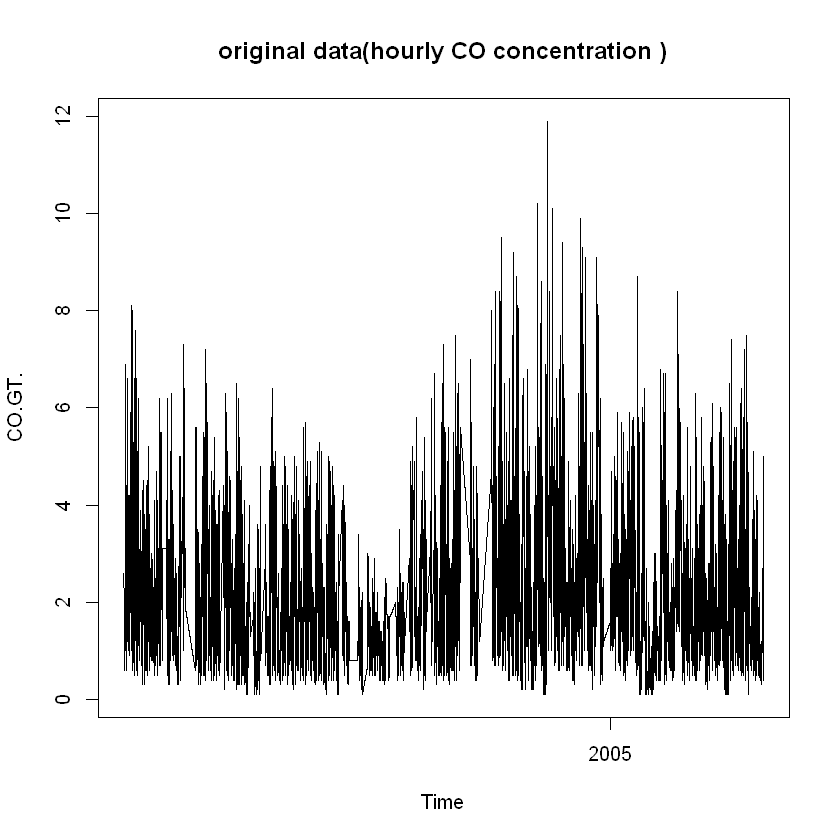

In [2]:
### Read the excel file
airquality<-read_excel("C:\\Users\\poonam\\Downloads\\AirQualityUCI\\AirQualityUCI.xlsx")
#airquality
### add the data to dataframe for manipulation
a<-data.frame(airquality)
#a
### Selecled the few columns(date, time and co) from the data frame 
df_co<-select(a,Date,Time,CO.GT.)
#df_co
testdata <- df_co
### manipulation of time columns( chose hour)
testdata1 <- mutate(testdata, Time = hour(testdata$Time))
testdata2 <- mutate(testdata1, date2 = update(testdata1$Date,hour = testdata1$Time))
#testdata2
cleanedset1 <- select(testdata2, date2, CO.GT.)
cleanedset1$CO.GT.[cleanedset1$CO.GT. == -200] <- NA
z <- zoo(select(cleanedset1,CO.GT.))
x <- na.fill(z, "extend")
b <- data.frame(x)
colnames(b) <- c("hourly averaged concentration CO")
cleanset2=cbind(cleanedset1,b)
cleanset3 = select(cleanset2,date2,'hourly averaged concentration CO')
x3.index <- select(cleanset3,date2)
x3.data <- select(cleanset3,'hourly averaged concentration CO')
x4 <-zoo(x3.data,x3.index$date2)
plot(x4,main="original data(hourly CO concentration )",xlab="Time",ylab="CO.GT.")

In [3]:
############# 2days data
ep_2days <- endpoints(x4,'days',2)
result_2days <- period.apply(x4,INDEX = ep_2days,FUN = mean)
df_result_2days <- as.data.frame(result_2days)
head(df_result_2days)

,result_2days
2004-03-10 23:00:00,1.966667
2004-03-12 23:00:00,2.464583
2004-03-14 23:00:00,2.540625
2004-03-16 23:00:00,3.041667
2004-03-18 23:00:00,2.792708
2004-03-20 23:00:00,2.467708


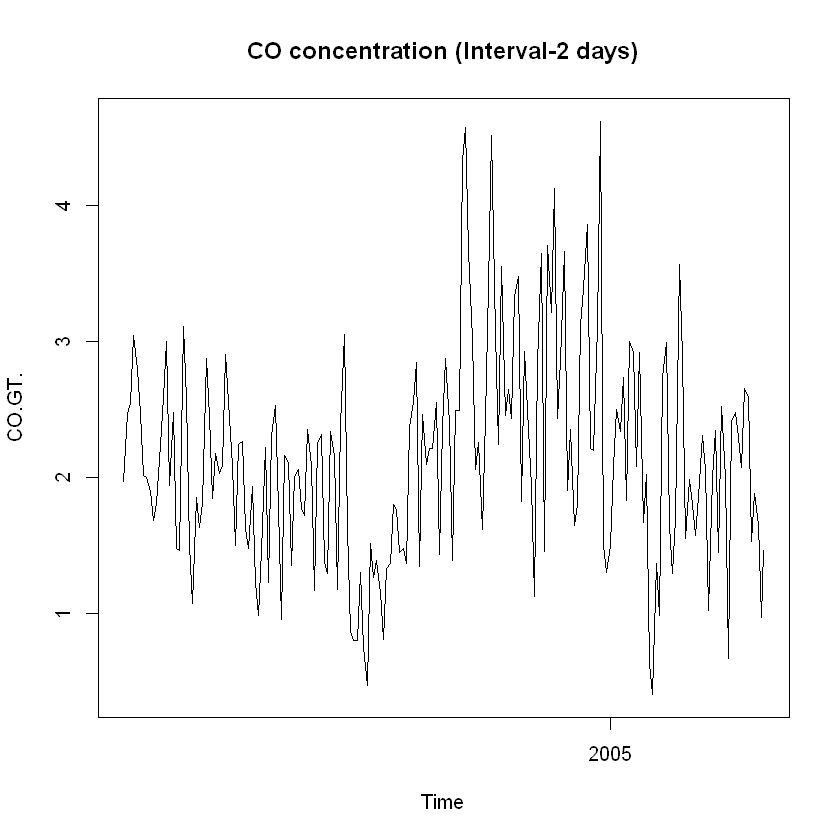

In [4]:
plot(result_2days,main="CO concentration (Interval-2 days)",xlab="Time",ylab="CO.GT.")


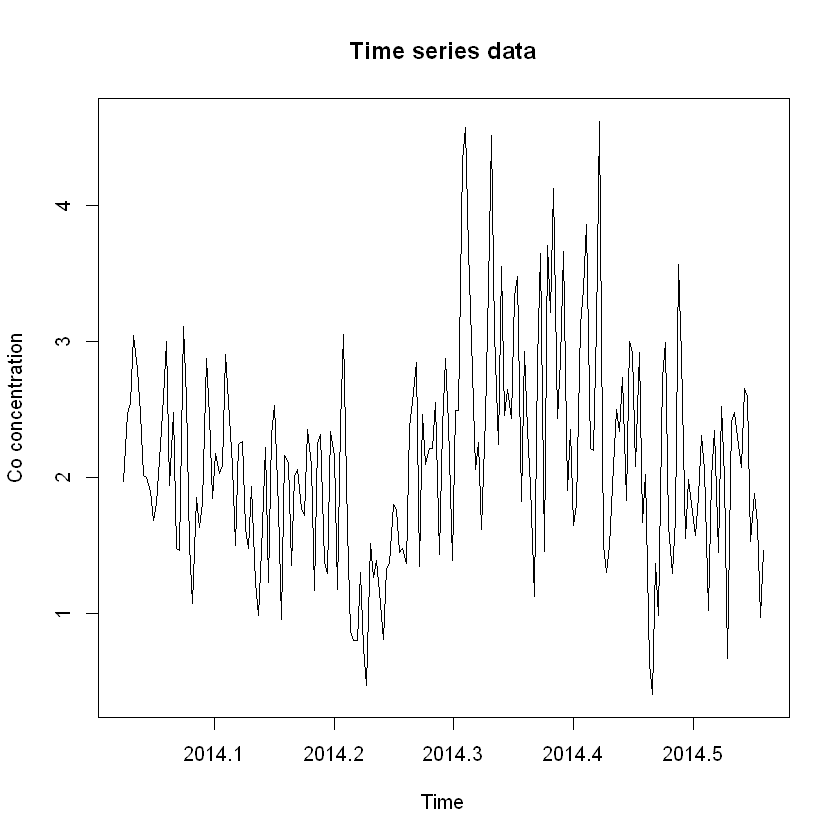

In [5]:
############convert the data to Time series
colnames(df_result_2days)<-c("co")
series<-ts(result_2days,frequency=365,start=c(2014,10))
#str(series)
### Plot the time series data
plot(series,main="Time series data",ylab="Co concentration")

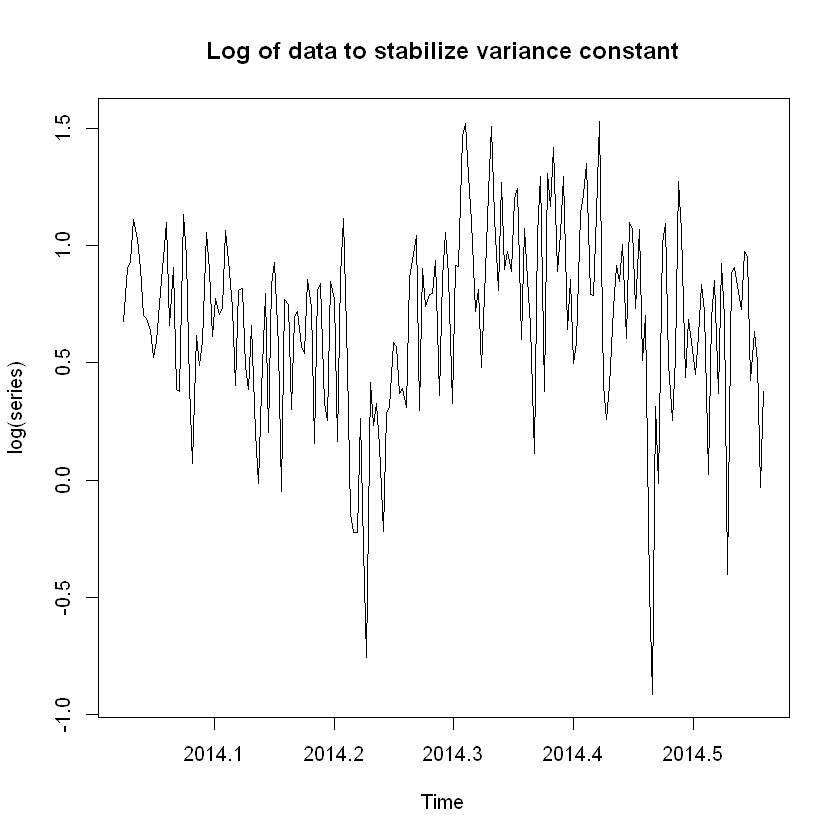

In [6]:
### Make the data stationary(log of data to stabilize non-constant variance)
plot(log(series),main="Log of data to stabilize variance constant")

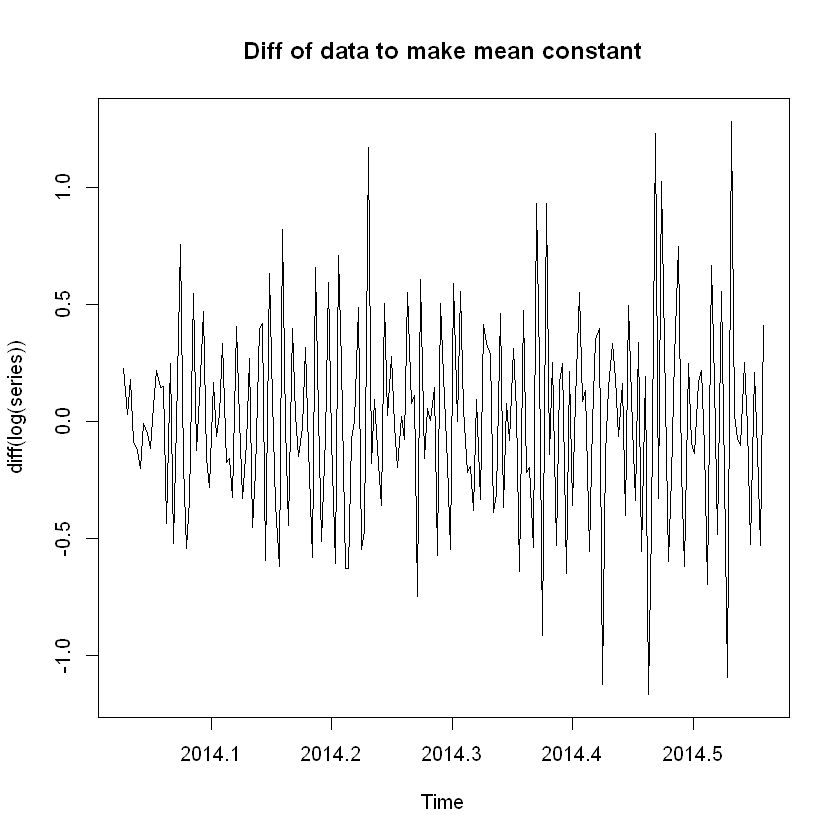

In [7]:
### Make the mean constant
plot(diff(log(series)),main="Diff of data to make mean constant")

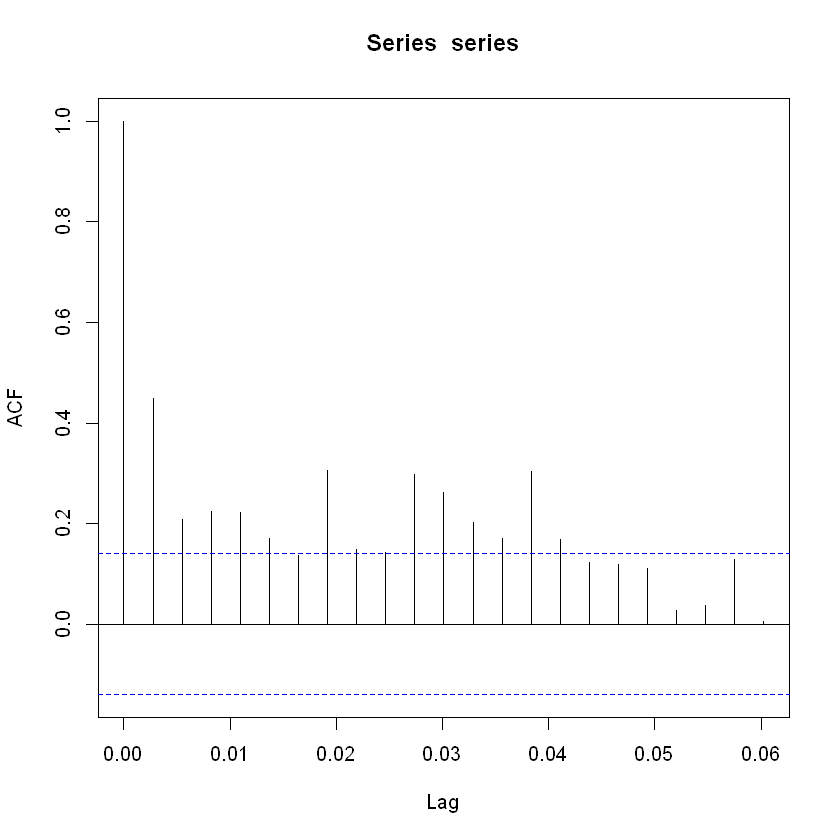

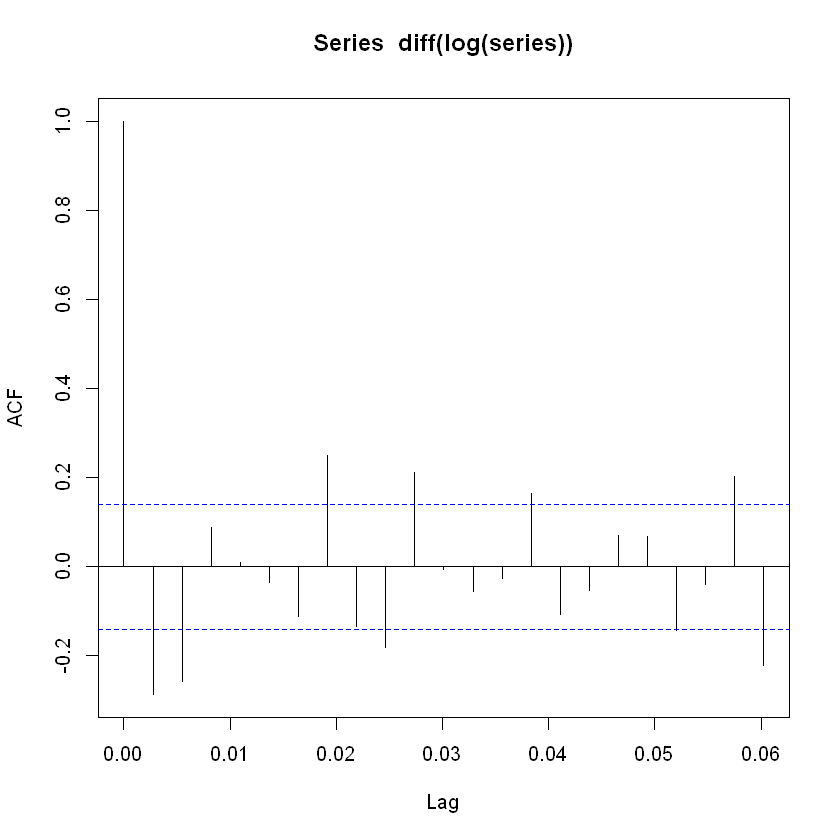

Series: series 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1      ma1      ma2    mean
      0.9577  -0.5483  -0.2783  2.1165
s.e.  0.0296   0.0777   0.0716  0.1865

sigma^2 estimated as 0.4823:  log likelihood=-204.87
AIC=419.74   AICc=420.05   BIC=436.13


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2)             with non-zero mean : 421.9541
 ARIMA(0,0,0)             with non-zero mean : 469.297
 ARIMA(1,0,0)             with non-zero mean : 428.0569
 ARIMA(0,0,1)             with non-zero mean : 431.6023
 ARIMA(0,0,0)             with zero mean     : 879.94
 ARIMA(1,0,2)             with non-zero mean : 420.7161
 ARIMA(0,0,2)             with non-zero mean : 431.4597
 ARIMA(1,0,1)             with non-zero mean : 429.9943
 ARIMA(1,0,3)             with non-zero mean : 422.3046
 ARIMA(0,0,3)             with non-zero mean : 430.2571
 ARIMA(2,0,1)             with non-zero mean : 430.6607
 ARIMA(2,0,3)             with non-zero mean : 423.0125
 ARIMA(1,0,2)             with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,2)             with non-zero mean : 419.7382

 Best model: ARIMA(1,0,2)             with non-zero mean 



Series: series 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1      ma1      ma2    mean
      0.9577  -0.5483  -0.2783  2.1165
s.e.  0.0296   0.0777   0.0716  0.1865

sigma^2 estimated as 0.4823:  log likelihood=-204.87
AIC=419.74   AICc=420.05   BIC=436.13

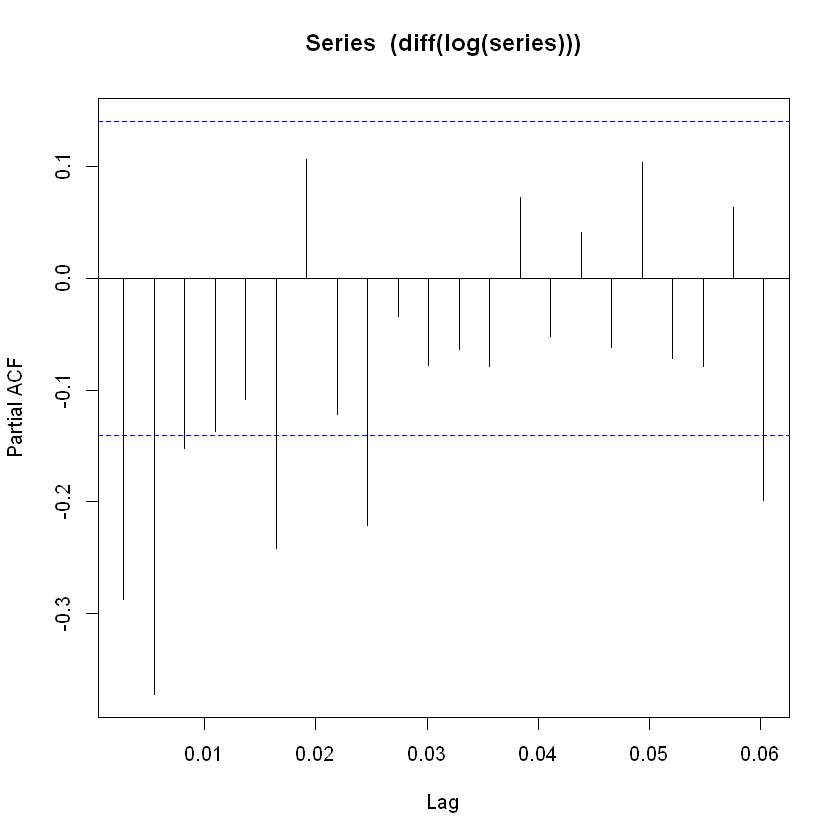

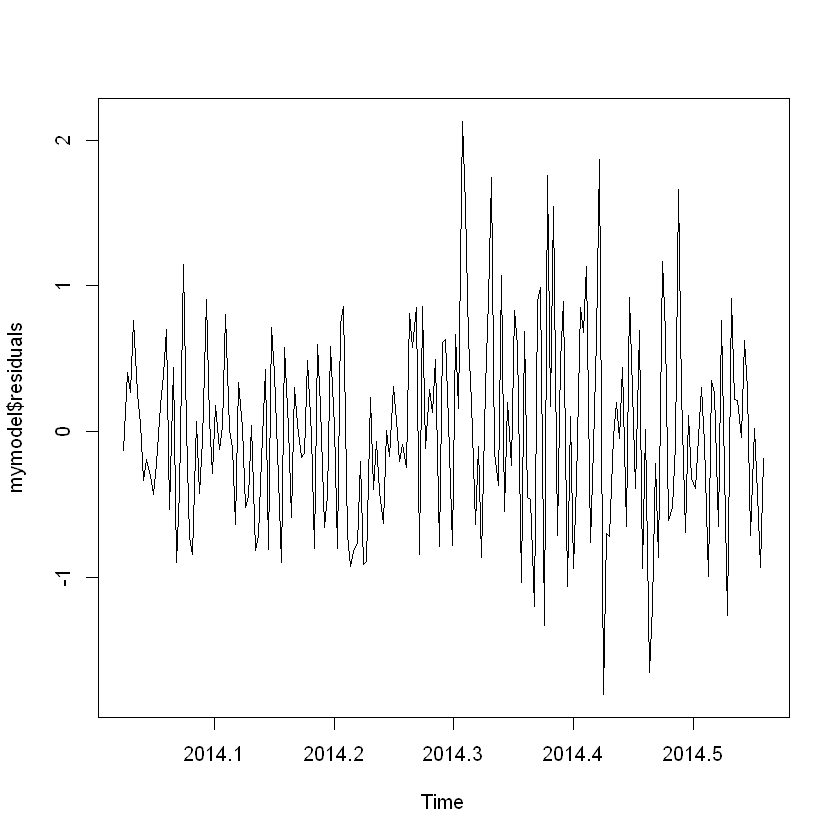

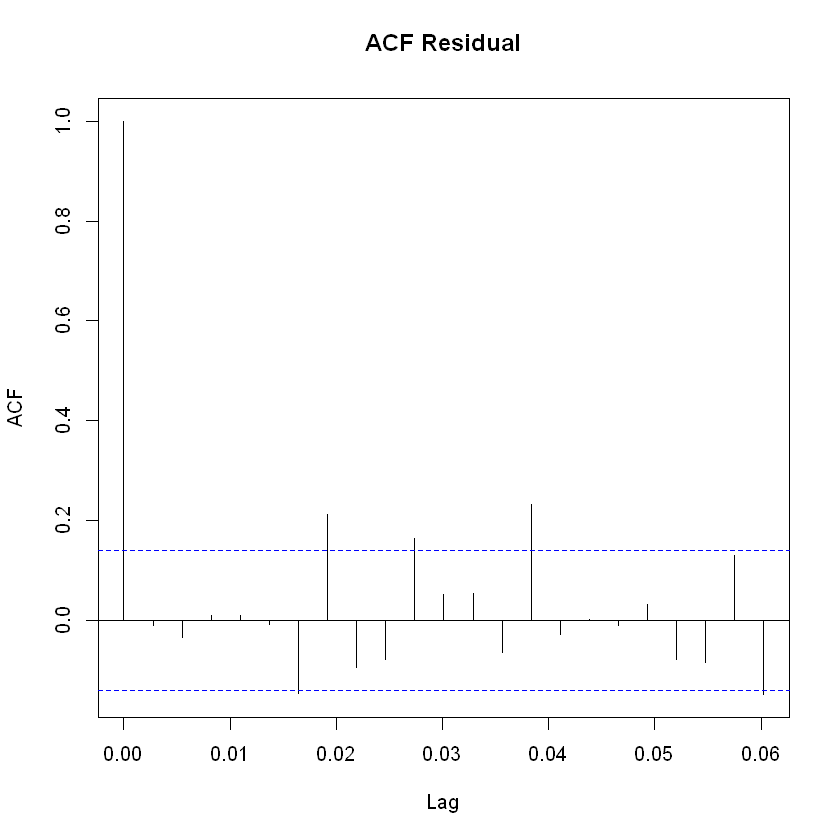

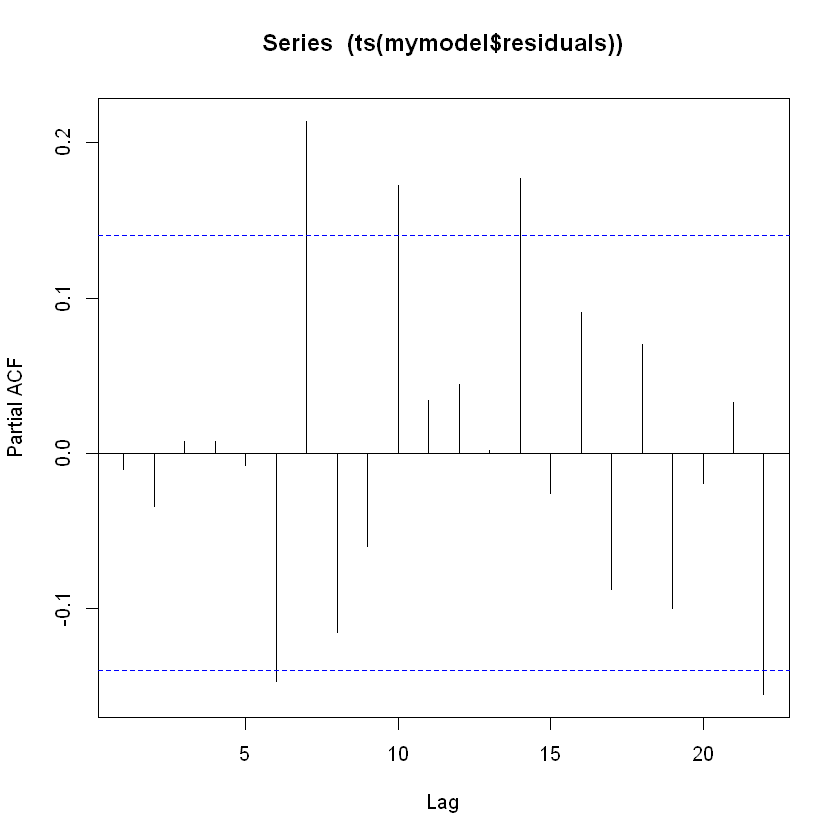

In [8]:
###  ARIMA Model
### Auto correlation factor on non stationary data
acf(series)
### Auto correlation factor on stationary data
acf(diff(log(series)))
### Partial auto correlation factor on stationary data
pacf((diff(log(series))))
### ARIMA model
mymodel<-auto.arima(series)
mymodel

### to see possible combination of p,d,q
auto.arima(series,ic="aic",trace=TRUE)

### plot the model
plot.ts(mymodel$residuals)
acf((mymodel$residuals),main='ACF Residual')
pacf((ts(mymodel$residuals)))

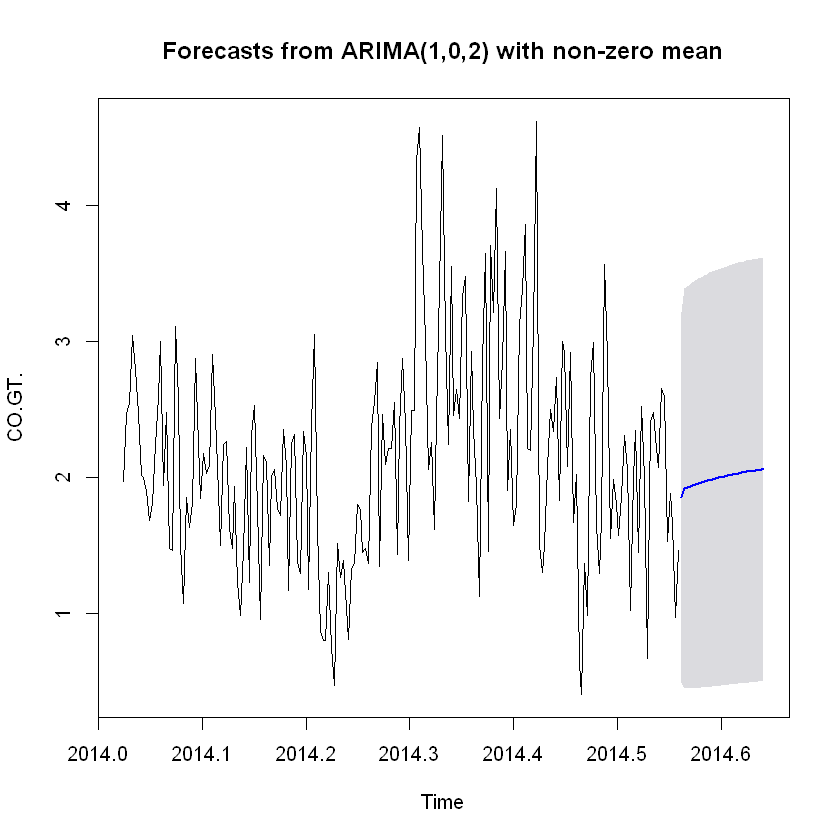

In [9]:
############# forcast the model 
myforecast<-forecast(mymodel,level=c(95),h=30)
plot(myforecast,xlab="Time",ylab="CO.GT.")

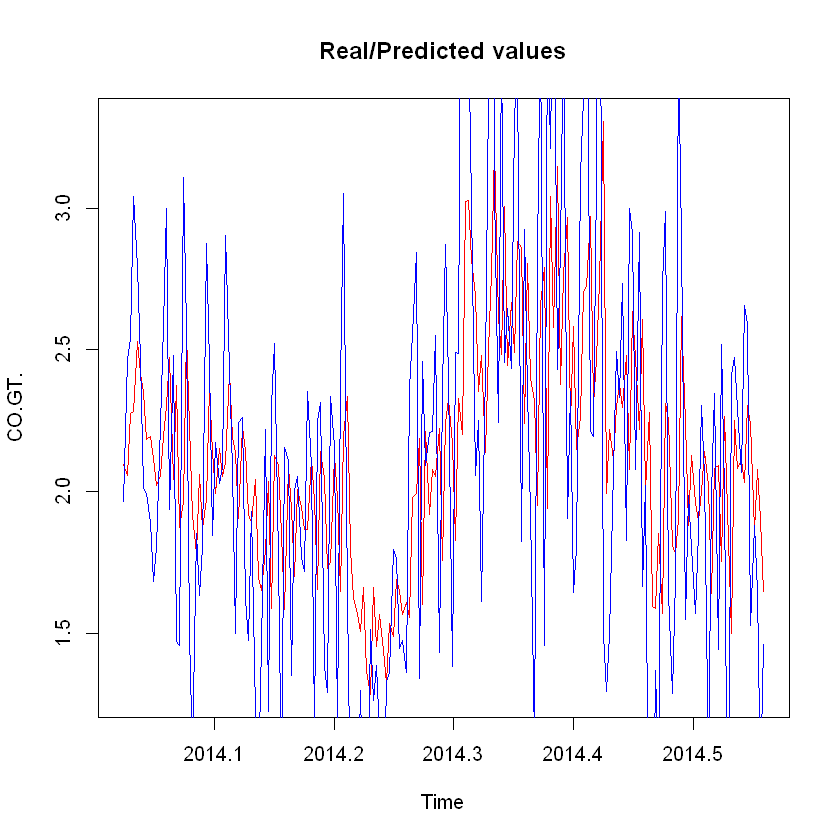

In [10]:
### line plot of real values and predicted values
predict_val=fitted(myforecast)
original_val=series
plot(predict_val,col="red",main="Real/Predicted values",ylab="CO.GT.")
lines(series,col="blue")

In [11]:
############ Accuracy measures of model
accuracy(myforecast)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.00433451,0.6873468,0.5457882,-13.92578,32.20918,NaN,-0.01008161


In [12]:
################ Correlation between real values and predicted values
res<-cor.test(predict_val,original_val,method="pearson")
res


	Pearson's product-moment correlation

data:  predict_val and original_val
t = 8.0139, df = 194, p-value = 1.015e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3854981 0.5971231
sample estimates:
      cor 
0.4987064 
